In [1]:
!pip install numpy==1.23.5
!pip install gensim
!pip install jax==0.4.13
!pip install jaxlib==0.4.13

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires nump

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

True

In [4]:
# Load dataset
data_path = '/content/drive/MyDrive/6. News Category Dataset/news_category.csv'
df = pd.read_csv(data_path)

In [5]:
# Inspect dataset
print('Shape:', df.shape)
print('Columns:', df.columns)
print('First few rows:')
print(df.head())
print('Unique categories:', df['category'].nunique())
print('Category distribution:')
print(df['category'].value_counts())

Shape: (11025, 2)
Columns: Index(['headline', 'category'], dtype='object')
First few rows:
                                            headline        category
0  How A New Documentary Captures The Complexity ...  CULTURE & ARTS
1  Twitch Bans Gambling Sites After Streamer Scam...            TECH
2  'Reboot' Is A Clever And Not Too Navel-Gazey L...  CULTURE & ARTS
3  Maury Wills, Base-Stealing Shortstop For Dodge...          SPORTS
4  Las Vegas Aces Win First WNBA Title, Chelsea G...          SPORTS
Unique categories: 5
Category distribution:
category
SPORTS            5077
TECH              2104
MONEY             1756
CULTURE & ARTS    1074
EDUCATION         1014
Name: count, dtype: int64


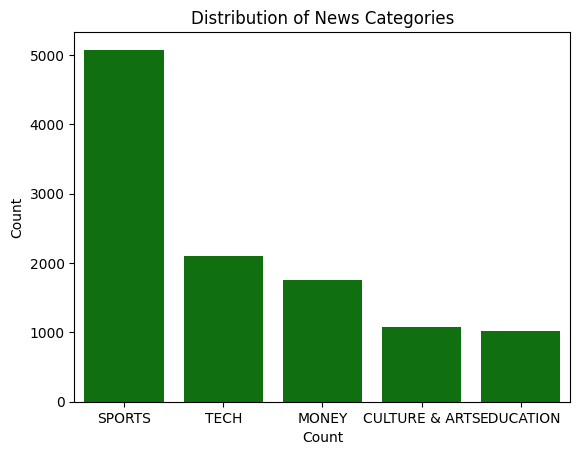

In [6]:
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, color ='green')
plt.title('Distribution of News Categories')
plt.ylabel('Count')
plt.xlabel('Count')
plt.show()

In [7]:
# Preprocessing and visualization
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
contractions = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "'s": " is",
    "'re": " are",
    "'ll": " will",
    "'ve": " have",
    "'m": " am"
}

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Replace contractions
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    # Remove URLs, mentions, hashtags, numbers, special characters
    text = re.sub(r'http\S+|@\w+|#\w+|\d+|[^a-zA-Z\s]', '', text)
    # Tokenize, remove stopwords, lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning to headlines
df['cleaned_headline'] = df['headline'].apply(clean_text)

# Verify preprocessing
print('Sample original vs cleaned headlines:')
for i in range(3):
    print(f"Original: {df['headline'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_headline'].iloc[i]}\n")

# Check for empty cleaned headlines
empty_count = (df['cleaned_headline'] == '').sum()
print(f'Number of empty cleaned headlines: {empty_count}')

Sample original vs cleaned headlines:
Original: How A New Documentary Captures The Complexity Of Being A Child Of Immigrants
Cleaned: new documentary capture complexity child immigrant

Original: Twitch Bans Gambling Sites After Streamer Scams Folks Out Of $200,000
Cleaned: twitch ban gambling site streamer scam folk

Original: 'Reboot' Is A Clever And Not Too Navel-Gazey Look Inside TV Reboots
Cleaned: areboot clever navelgazey look inside tv reboots

Number of empty cleaned headlines: 0


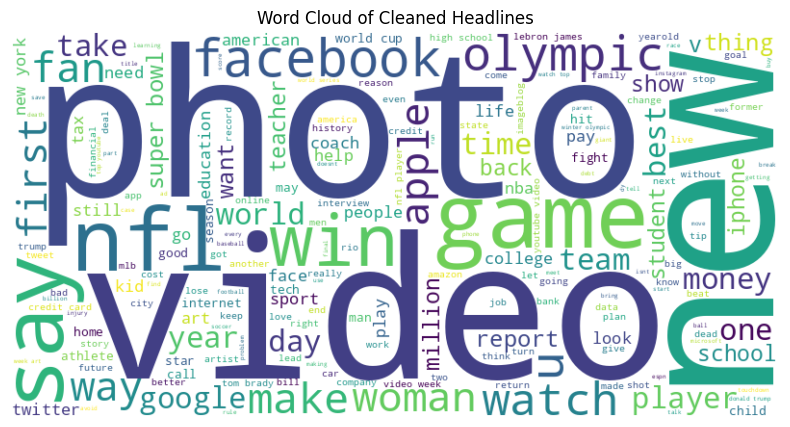

In [8]:
# Visualize word cloud
text = ' '.join(df['cleaned_headline'])
if text.strip():  # Ensure text is not empty
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Cleaned Headlines')
    plt.show()
else:
    print('Error: No words available for word cloud.')

In [9]:
# Train-test split, tokenization, padding, and label encoding
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Train-test split (80/20)
X = df['cleaned_headline']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify split
print(f'Training set size: {len(X_train)} samples')
print(f'Test set size: {len(X_test)} samples')
print(f'Total samples: {len(X_train) + len(X_test)}')

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
# Verify tokenization
print(f'Vocabulary size: {len(tokenizer.word_index) + 1}')
print('Sample tokenized sequence (first training example):', X_train_seq[0])
print('Sample original text:', X_train.iloc[0])

Training set size: 8820 samples
Test set size: 2205 samples
Total samples: 11025
Vocabulary size: 12052
Sample tokenized sequence (first training example): [129, 335, 242, 79, 129, 439]
Sample original text: return king case lebron return cleveland


In [10]:
# Percentile-based padding
seq_lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(seq_lengths, 95))
print(f'Max sequence length (95th percentile): {max_length}')
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Max sequence length (95th percentile): 11


In [11]:
# Verify padding
print(f'Shape of X_train_pad: {X_train_pad.shape}')
print(f'Shape of X_test_pad: {X_test_pad.shape}')
print('Sample padded sequence (first training example):', X_train_pad[0])

Shape of X_train_pad: (8820, 11)
Shape of X_test_pad: (2205, 11)
Sample padded sequence (first training example): [129 335 242  79 129 439   0   0   0   0   0]


In [12]:
# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)
# Verify encoding
print(f'Number of classes: {num_classes}')
print(f'Encoded classes: {le.classes_}')
print('Sample encoded labels (first 5 training):', y_train_enc[:5])
print('Sample original labels (first 5 training):', y_train.iloc[:5].values)

Number of classes: 5
Encoded classes: ['CULTURE & ARTS' 'EDUCATION' 'MONEY' 'SPORTS' 'TECH']
Sample encoded labels (first 5 training): [3 0 3 2 3]
Sample original labels (first 5 training): ['SPORTS' 'CULTURE & ARTS' 'SPORTS' 'MONEY' 'SPORTS']


In [13]:
# Model building
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
import gensim.downloader as api

# Model parameters (from previous step)
vocab_size = len(tokenizer.word_index) + 1
max_length = X_train_pad.shape[1]  # From padding step
num_classes = len(le.classes_)  # From label encoding
embedding_dim = 100  # For trainable embeddings
embedding_dim_glove = 50  # For GloVe embeddings

# Model 1: Simple RNN with trainable Embedding
rnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(64),
    Dense(num_classes, activation='softmax')
])

rnn_model.build(input_shape=(None, max_length))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Model 2: LSTM with trainable Embedding
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

lstm_model.build(input_shape=(None, max_length))

In [15]:
# Model 3: LSTM with pretrained GloVe embeddings
# Load GloVe embeddings
glove_model = api.load('glove-wiki-gigaword-50')
embedding_matrix = np.zeros((vocab_size, embedding_dim_glove))
for word, i in tokenizer.word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]
    # Else, keep zeros for words not in GloVe

glove_lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim_glove, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

glove_lstm_model.build(input_shape=(None, max_length))

[==================================================] 100.0% 66.0/66.0MB downloaded


In [16]:
# Compile models (part of Task 3.3, included for continuity)
for model, name in [(rnn_model, 'Simple RNN'), (lstm_model, 'LSTM'), (glove_lstm_model, 'GloVe LSTM')]:
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(f'\n{name} Summary:')
    model.summary()

# Verify GloVe embedding matrix
print(f'\nGloVe embedding matrix shape: {embedding_matrix.shape}')
print(f'Number of words with GloVe embeddings: {np.sum(np.any(embedding_matrix != 0, axis=1))}')


Simple RNN Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11, 100)        │     1,205,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,216,085 (4.64 MB)

 Trainable params: 1,216,085 (4.64 MB)

 Non-trainable params: 0 (0.00 B)


LSTM Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 11, 100)        │     1,205,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,247,765 (4.76 MB)

 Trainable params: 1,247,765 (4.76 MB)

 Non-trainable params: 0 (0.00 B)


GloVe LSTM Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 11, 50)         │       602,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 632,365 (2.41 MB)

 Trainable params: 29,765 (116.27 KB)

 Non-trainable params: 602,600 (2.30 MB)


GloVe embedding matrix shape: (12052, 50)
Number of words with GloVe embeddings: 10847


In [18]:
# Model training, visualization, and evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Train models
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
models = {'RNN': rnn_model, 'LSTM': lstm_model, 'GloVe LSTM': glove_lstm_model}
histories = {}

for name, model in models.items():
    print(f'Training {name}...')
    history = model.fit(
        X_train_pad, y_train_enc,
        validation_data=(X_test_pad, y_test_enc),
        epochs=25,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    histories[name] = history.history

Training RNN...
Epoch 1/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9849 - loss: 0.0575 - val_accuracy: 0.8036 - val_loss: 0.7478
Epoch 2/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9904 - loss: 0.0313 - val_accuracy: 0.8077 - val_loss: 0.8150
Epoch 3/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9943 - loss: 0.0197 - val_accuracy: 0.8159 - val_loss: 0.7993
Epoch 4/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9985 - loss: 0.0099 - val_accuracy: 0.8113 - val_loss: 0.8720
Training LSTM...
Epoch 1/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8751 - loss: 0.3711 - val_accuracy: 0.8454 - val_loss: 0.4727
Epoch 2/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9693 - loss: 0.1124 - val_accuracy: 0.8426 - val_loss: 0.5656
Epoch 3/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9881 - loss: 0.0506 - val_accuracy: 0.8327 - val_loss: 0.6494
Epoch 4/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy

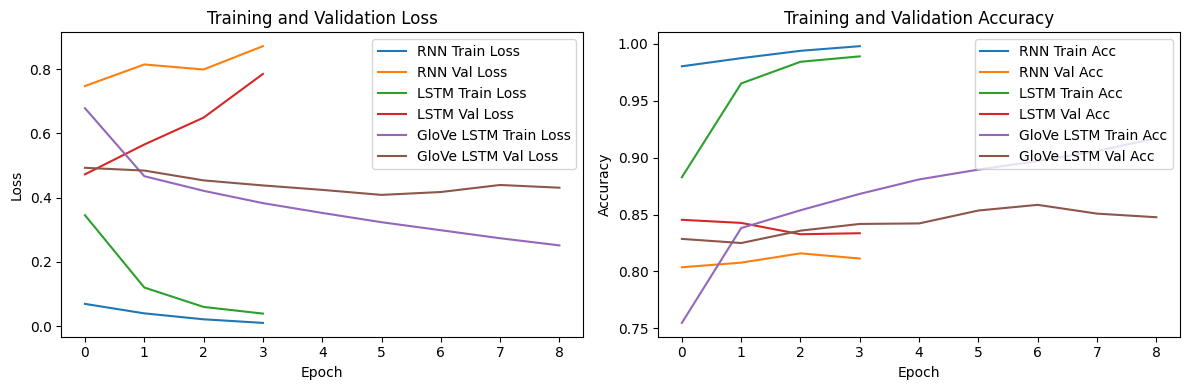

In [19]:
# Visualize training performance
plt.figure(figsize=(12, 4))
for name, history in histories.items():
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label=f'{name} Train Loss')
    plt.plot(history['val_loss'], label=f'{name} Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label=f'{name} Train Acc')
    plt.plot(history['val_accuracy'], label=f'{name} Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

RNN Evaluation:
Accuracy: 0.8036
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.72      0.65      0.68       224
     EDUCATION       0.79      0.58      0.66       193
         MONEY       0.74      0.75      0.75       338
        SPORTS       0.82      0.96      0.89      1020
          TECH       0.86      0.65      0.74       430

      accuracy                           0.80      2205
     macro avg       0.79      0.72      0.74      2205
  weighted avg       0.80      0.80      0.80      2205



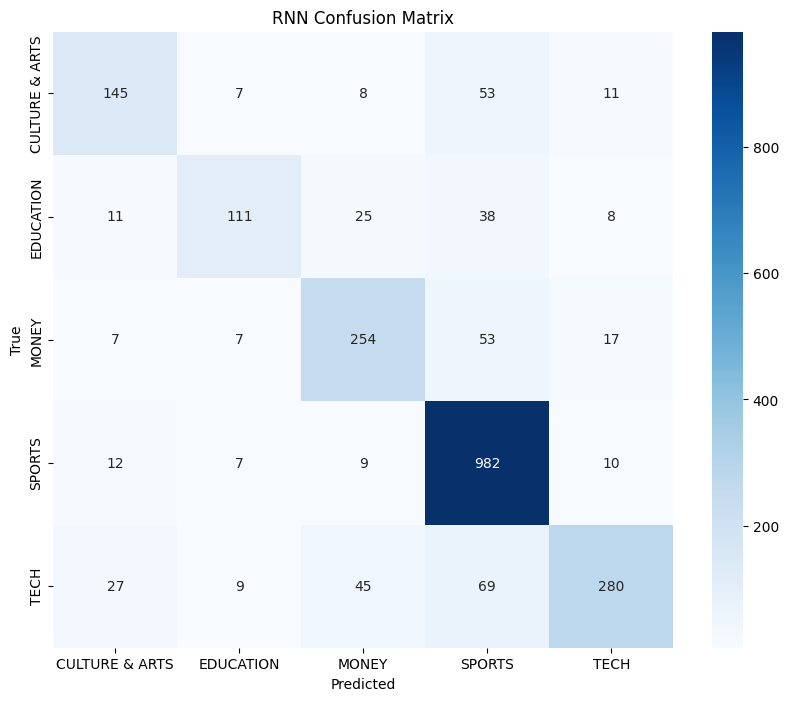

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

LSTM Evaluation:
Accuracy: 0.8454
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.81      0.69      0.75       224
     EDUCATION       0.73      0.65      0.69       193
         MONEY       0.70      0.86      0.77       338
        SPORTS       0.93      0.94      0.93      1020
          TECH       0.85      0.77      0.81       430

      accuracy                           0.85      2205
     macro avg       0.80      0.78      0.79      2205
  weighted avg       0.85      0.85      0.84      2205



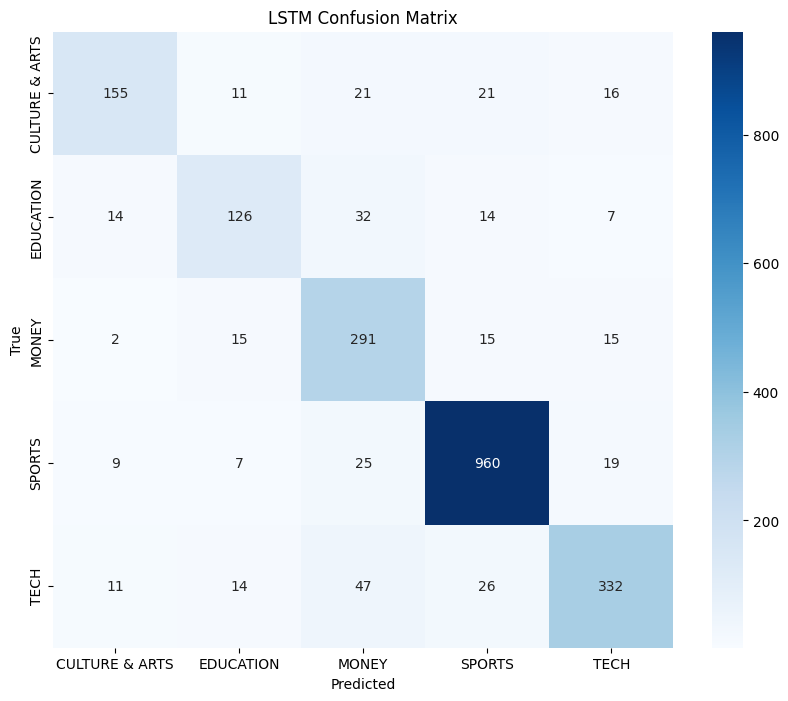

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

GloVe LSTM Evaluation:
Accuracy: 0.8535
Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.72      0.81      0.76       224
     EDUCATION       0.69      0.70      0.70       193
         MONEY       0.81      0.85      0.83       338
        SPORTS       0.94      0.92      0.93      1020
          TECH       0.84      0.80      0.82       430

      accuracy                           0.85      2205
     macro avg       0.80      0.81      0.81      2205
  weighted avg       0.86      0.85      0.85      2205



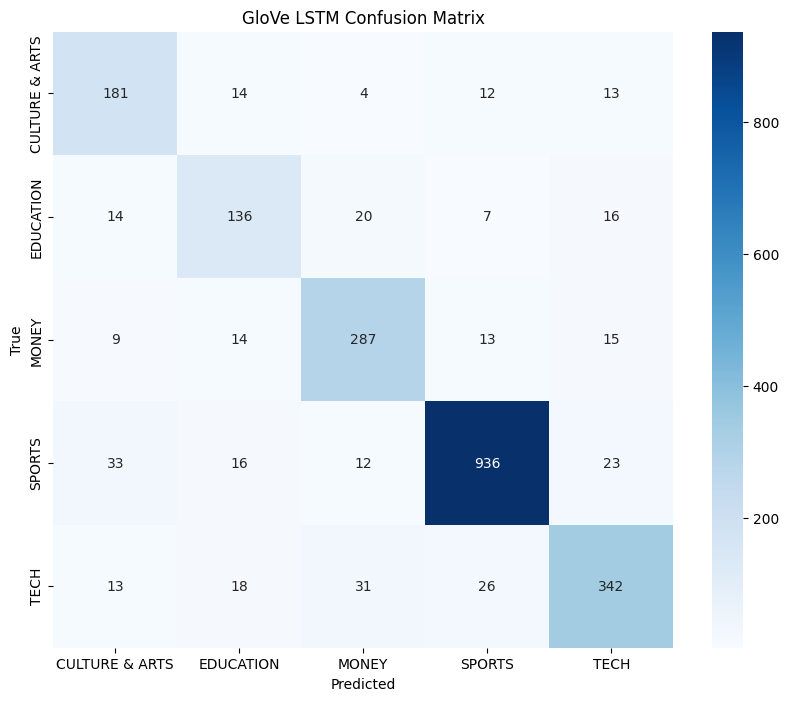

In [20]:
# Evaluate models
accuracies = {}
for name, model in models.items():
    y_pred = model.predict(X_test_pad).argmax(axis=1)
    accuracy = accuracy_score(y_test_enc, y_pred)
    accuracies[name] = accuracy
    print(f'\n{name} Evaluation:')
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

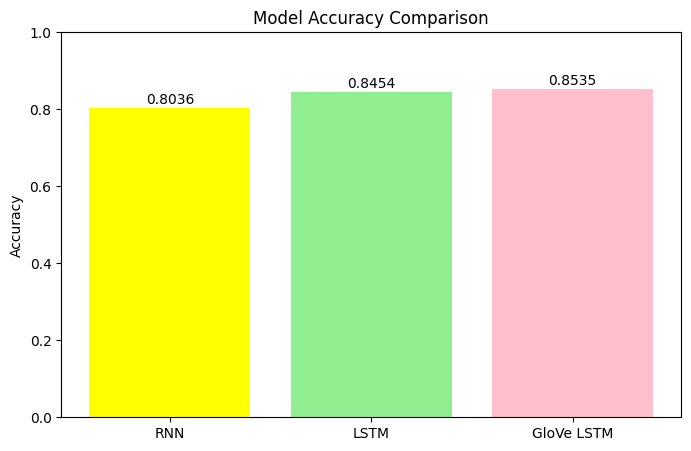

In [21]:
# Compare model accuracies
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['yellow', 'lightgreen', 'pink'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

In [22]:
# Verify training completion
for name, history in histories.items():
    print(f'{name} trained for {len(history["loss"])} epochs')

RNN trained for 4 epochs
LSTM trained for 4 epochs
GloVe LSTM trained for 9 epochs


In [23]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


In [24]:
# Gradio interface for real-time prediction
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define prediction function
def predict_headline(headline, model=glove_lstm_model, tokenizer=tokenizer, max_length=max_length, le=le):
    # Preprocess input headline
    cleaned = clean_text(headline)
    if not cleaned.strip():
        return "Error: Input headline is empty after preprocessing."
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    # Predict
    pred = model.predict(padded).argmax(axis=1)
    return le.inverse_transform(pred)[0]

# Test prediction function
test_headline = "Las Vegas Aces Win First WNBA Title"
print(f'Test headline: {test_headline}')
print(f'Predicted category: {predict_headline(test_headline)}')

Test headline: Las Vegas Aces Win First WNBA Title
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted category: SPORTS


In [25]:
# Create Gradio interface
interface = gr.Interface(
    fn=predict_headline,
    inputs=gr.Textbox(label="Enter a news headline", placeholder="e.g., Las Vegas Aces Win First WNBA Title"),
    outputs=gr.Text(label="Predicted Category"),
    title="News Headline Classifier",
    description="Enter a news headline to predict its category using an LSTM model with GloVe embeddings."
)

# Launch interface
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9d3a60226f06038606.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
